# Libraries

In [1219]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.ensemble import GradientBoostingClassifier as GBC, GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data Preprocessing

## Import & First look

In [1220]:
#data0 = pd.read_csv('./EURUSD1440.csv',sep='\t',names=['time','open','high','low','close','volume'])

data = pd.read_csv('../data/EUR_USD Historical Data 2.csv')
changes = [ float(i[:-1]) for i in data['Change %']]
data['Change %'] = changes
data

,Date,Price,Open,High,Low,Change %
0,"Mar 01, 2021",1.2047,1.2079,1.2102,1.2027,-0.22
1,"Feb 26, 2021",1.2074,1.2176,1.2185,1.2062,-0.84
2,"Feb 25, 2021",1.2176,1.2163,1.2243,1.2155,0.10
3,"Feb 24, 2021",1.2164,1.2150,1.2176,1.2109,0.12
4,"Feb 23, 2021",1.2149,1.2155,1.2181,1.2135,-0.04
...,...,...,...,...,...,...
4995,"Jan 07, 2002",0.8935,0.8951,0.8998,0.8880,-0.17
4996,"Jan 04, 2002",0.8950,0.8987,0.9003,0.8937,-0.51
4997,"Jan 03, 2002",0.8996,0.9039,0.9062,0.8976,-0.44
4998,"Jan 02, 2002",0.9036,0.8896,0.9069,0.8883,1.59


In [1221]:
fake = pd.DataFrame()
fake['Date'] = data['Date']
fake['Close'] = data['Price']
fake['Max.'] = data['High']
fake['Min.'] = data['Low']
fake

,Date,Close,Max.,Min.
0,"Mar 01, 2021",1.2047,1.2102,1.2027
1,"Feb 26, 2021",1.2074,1.2185,1.2062
2,"Feb 25, 2021",1.2176,1.2243,1.2155
3,"Feb 24, 2021",1.2164,1.2176,1.2109
4,"Feb 23, 2021",1.2149,1.2181,1.2135
...,...,...,...,...
4995,"Jan 07, 2002",0.8935,0.8998,0.8880
4996,"Jan 04, 2002",0.8950,0.9003,0.8937
4997,"Jan 03, 2002",0.8996,0.9062,0.8976
4998,"Jan 02, 2002",0.9036,0.9069,0.8883


In [1222]:
data['Change'] = 0

for i in range(data.shape[0]-1):
    data.loc[i,'Change'] = data.loc[i,'Price']-data.loc[i+1,'Price']
data

,Date,Price,Open,High,Low,Change %,Change
0,"Mar 01, 2021",1.2047,1.2079,1.2102,1.2027,-0.22,-0.0027
1,"Feb 26, 2021",1.2074,1.2176,1.2185,1.2062,-0.84,-0.0102
2,"Feb 25, 2021",1.2176,1.2163,1.2243,1.2155,0.10,0.0012
3,"Feb 24, 2021",1.2164,1.2150,1.2176,1.2109,0.12,0.0015
4,"Feb 23, 2021",1.2149,1.2155,1.2181,1.2135,-0.04,-0.0005
...,...,...,...,...,...,...,...
4995,"Jan 07, 2002",0.8935,0.8951,0.8998,0.8880,-0.17,-0.0015
4996,"Jan 04, 2002",0.8950,0.8987,0.9003,0.8937,-0.51,-0.0046
4997,"Jan 03, 2002",0.8996,0.9039,0.9062,0.8976,-0.44,-0.0040
4998,"Jan 02, 2002",0.9036,0.8896,0.9069,0.8883,1.59,0.0141


## Prediction

In [1223]:
data['Y'] = 0
data['Y_pos'] = 0
for i in range(1,data.shape[0]):
    data.loc[i,'Y'] = data.loc[i-1,'Change']
    if data.loc[i,'Y']>0:
        data.loc[i,'Y_pos'] = 1
data

,Date,Price,Open,High,Low,Change %,Change,Y,Y_pos
0,"Mar 01, 2021",1.2047,1.2079,1.2102,1.2027,-0.22,-0.0027,0.0000,0
1,"Feb 26, 2021",1.2074,1.2176,1.2185,1.2062,-0.84,-0.0102,-0.0027,0
2,"Feb 25, 2021",1.2176,1.2163,1.2243,1.2155,0.10,0.0012,-0.0102,0
3,"Feb 24, 2021",1.2164,1.2150,1.2176,1.2109,0.12,0.0015,0.0012,1
4,"Feb 23, 2021",1.2149,1.2155,1.2181,1.2135,-0.04,-0.0005,0.0015,1
...,...,...,...,...,...,...,...,...,...
4995,"Jan 07, 2002",0.8935,0.8951,0.8998,0.8880,-0.17,-0.0015,-0.0004,0
4996,"Jan 04, 2002",0.8950,0.8987,0.9003,0.8937,-0.51,-0.0046,-0.0015,0
4997,"Jan 03, 2002",0.8996,0.9039,0.9062,0.8976,-0.44,-0.0040,-0.0046,0
4998,"Jan 02, 2002",0.9036,0.8896,0.9069,0.8883,1.59,0.0141,-0.0040,0


## High-Low Range

In [1224]:
data['HL_Range'] = (data['High']-data['Low'])/data['Price']

## Date

In [1225]:
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True) 

In [1226]:
dates = data['Date']

data['year'] = dates.apply(lambda x: x.year)
data['month'] = dates.apply(lambda x: x.month)
data['day'] = dates.apply(lambda x: x.day)

## RSI Indicator

In [1227]:
# https://www.tradingheroes.com/rsi-indicator-explained/
# J. Welles Wilder in his 1978 book, New Concepts in Technical Trading Systems

In [1228]:
pos = 0
neg = 0
n = 20
rsi_n = 'RSI ' + str(n)
negatemp = 0
posatemp = 0
data[rsi_n] = 0
data['RS'] = 0
data['UpAvg'] = 0
data['DownAvg'] = 0
data['Overbought'] = 0
data['Oversold'] = 0
pos0 = 0
neg0 = 0
first=data.shape[0]-n   #RSI(20) can only be calculated once we have 20 or more data points

for j in list(data.loc[first:,'Change']):   #calculate rsi with the n first data points
        
        if j>0:
            pos0 += j
        if j<0:
            neg0 += j
            
nega = np.abs(neg0)/n
posa = pos0/n
data.loc[first,'UpAvg'] = posa
data.loc[first,'DownAvg'] = nega
rs = posa/nega #0

rsi = 100-(100/(1+rs))
data.loc[first,rsi_n] = rsi

if rsi > 60:
    data.loc[first,'Overbought'] = 1
if rsi < 40:
    data.loc[first,'Oversold'] = 1

for i in list(range(first-1,-1,-1)):    #calculate rsi through iteration
    
    new_change = data.loc[i,'Change']

    if new_change<0:
        
        nega = (nega*(n-1)+np.abs(new_change))/n
        posa = (posa*(n-1))/n
    elif new_change>0:
        
        posa = (posa*(n-1)+new_change)/n
        nega = (nega*(n-1))/n
    else:
        posa = (posa*(n-1))/n
        nega = (nega*(n-1))/n
    
    data.loc[i,'UpAvg'] = posa
    data.loc[i,'DownAvg'] = nega
    rs = posa/nega
    data.loc[i,'RS'] = rs
    rsi = 100-(100/(1+rs))
    data.loc[i,rsi_n] = rsi
    if rsi > 60:
        data.loc[i,'Overbought'] = 1
    if rsi < 40:
        data.loc[i,'Oversold'] = 1

## MACD Indicator

In [1229]:
# https://www.avatrade.es/educacion/professional-trading-strategies/macd-trading-strategies
# MACD = EMA (12) – EMA (26)
# (Close−EMA(previous period))*0.1538+EMA(previous period)
# Después de obtener el MACD, se calcula, a su vez, su media móvil exponencial.
# Para realizar este cálculo se suele emplear una media de 9 períodos. Esta media móvil se denomina Señal.

### MACD

In [1230]:
n1 = 15
n2 = 30

mult = lambda x: 2/(x+1) 

data['MACD'] = 0 
data['MACD_15'] = 0 
data['MACD_30'] = 0

for n in [n1,n2]:
    
    first=data.shape[0]-n   #EMA can only be calculated once we have 20 or more data points
    
    ema = np.mean(list(data.loc[first:,'Price']))   #calculate sma with the n first data points
    tag = 'MACD_'+str(n)
    data.loc[first,tag] = ema
    if n == n2 :
        data.loc[first,'MACD'] = data.loc[first,'MACD_15']-data.loc[first,'MACD_30']
    for i in list(range(first-1,-1,-1)):
        
        new_price = data.loc[i,'Price']
        
        ema = (new_price-ema)*mult(n)+ema
        
        data.loc[i,tag] = ema
        if n == n2 :
            data.loc[i,'MACD'] = data.loc[i,'MACD_15']-data.loc[i,'MACD_30']
            
#df = data.iloc[::-1].reset_index(drop=True)

#exp1 = df.Price.ewm(span=15, adjust=False).mean()
#exp2 = df.Price.ewm(span=30, adjust=False).mean()
#macd = exp1-exp2
#exp3 = macd.ewm(span=10, adjust=False).mean()

### Signal

In [1231]:
n3 = 10

data['Signal'] = 0

first=data.shape[0]-n2+1-n3
ema_signal = np.mean(list(data.loc[first:first+n3-1,'MACD']))   #calculate sma with the n first data points

data.loc[first,'Signal'] = ema_signal

for i in list(range(first-1,-1,-1)):
    
    new_MACD = data.loc[i,'MACD']
    
    ema_signal = (new_MACD-ema_signal)*mult(n3)+ema_signal
    
    data.loc[i,'Signal'] = ema_signal
    
data['MACD - Signal'] = data['MACD'] - data['Signal']

## ADX Indicator

In [1232]:
# https://blog.quantinsti.com/adx-indicator-python/
# https://school.stockcharts.com/doku.php?id=technical_indicators:average_directional_index_adx

### True Range

In [1233]:
range1 = data['High']-data['Low']
range2 = np.abs(data['High']-(data['Price']-data['Change']))
range3 = np.abs(data['Low']-(data['Price']-data['Change']))

data['TrueRange'] = np.max([range1,range2,range3],axis=0)

### +/- DM

In [1234]:
data['+DM'] = 0
data['-DM'] = 0

for i in range(data.shape[0]-1):
    pos = data.loc[i,'High']-data.loc[i+1,'High']
    neg = data.loc[i+1,'Low']-data.loc[i,'Low']   # NOTICE HOW i and i+1 are reversed for neg
    if pos>neg and pos>0:
        data.loc[i,'+DM'] = pos
    elif pos<neg and neg>0:
        data.loc[i,'-DM'] = neg    

### Smoothed values

#### Averaged True Range

In [1235]:
n = 15

data['ATR'] = 0 

first=data.shape[0]-n   # can only be calculated once we have 15 or more data points
    
atr = np.mean(list(data.loc[first:,'TrueRange']))   #calculate with the n first data points
data.loc[first,'ATR'] = atr

for i in list(range(first-1,-1,-1)):
        
    new_range = data.loc[i,'TrueRange']
        
    atr = (atr*(n-1)+new_range)/n
        
    data.loc[i,'ATR'] = atr
    

#### Smooth +/- DM

In [1236]:
n=15

data['Smooth_+DM'] = 0 
data['Smooth_-DM'] = 0 

first=data.shape[0]-n   #can only be calculated once we have 15 or more data points
    
pos = np.mean(list(data.loc[first:,'+DM']))   #calculate with the n first data points
neg = np.mean(list(data.loc[first:,'-DM']))

data.loc[first,'Smooth_+DM'] = pos
data.loc[first,'Smooth_-DM'] = neg

for i in list(range(first-1,-1,-1)):
        
    new_neg = data.loc[i,'-DM']
    new_pos = data.loc[i,'+DM']
        
    pos = (pos*(n-1)+new_pos)/n
    neg = (neg*(n-1)+new_neg)/n
        
    data.loc[i,'Smooth_+DM'] = pos
    data.loc[i,'Smooth_-DM'] = neg


### IDX

In [1237]:
n=15
data['ADX'] = 0 

data['+DI'] = (data['Smooth_+DM']/data['ATR'])*100
data['-DI'] = (data['Smooth_-DM']/data['ATR'])*100

DX = np.abs((data['+DI']-data['-DI'])/(data['+DI']+data['-DI']))*100
data['DX'] = DX

first=data.shape[0]-n-n+1   #can only be calculated once we have 15 or more data points

adx = np.mean(list(data.loc[first:first+n-1,'DX']))

data.loc[first,'ADX'] = adx

for i in list(range(first-1,-1,-1)):
        
    new_adx = data.loc[i,'DX']
        
    adx = (adx*(n-1)+new_adx)/n
        
    data.loc[i,'ADX'] = adx


## Moving Averages

### Regular Average (Period = 50)

In [1238]:
df = data.iloc[::-1].reset_index(drop=True)['Price']

In [1239]:
ma50 = df.rolling(50).mean()

data['MA_50'] = ma50.iloc[::-1].reset_index(drop=True)

data['MA_50_diff'] = 0

for i in range(0,data.shape[0]-1):
    data.loc[i,'MA_50_diff'] = data.loc[i,'MA_50'] - data.loc[i+1,'MA_50']

### Regular Average (Period = 100)

In [1240]:
ma100 = df.rolling(100).mean()

data['MA_100'] = ma100.iloc[::-1].reset_index(drop=True)

data['MA_100_diff'] = 0

for i in range(0,data.shape[0]-1):
    data.loc[i,'MA_100_diff'] = data.loc[i,'MA_100'] - data.loc[i+1,'MA_100']

### Exponential Average (Period = 150)

In [1241]:
exp1 = df.ewm(span=150, adjust=False).mean()

data['EMA_150'] = exp1.iloc[::-1].reset_index(drop=True)

data['EMA_150_diff'] = 0

for i in range(0,data.shape[0]-1):
    data.loc[i,'EMA_150_diff'] = data.loc[i,'EMA_150'] - data.loc[i+1,'EMA_150']

## Dropping rows

In [1242]:
data = data.drop(data[data['year']==2002].index)
data2 = data[data['year']==2021]
data = data.drop(data[data['year']==2021].index)
#data = data.drop(data[data['year']<2019].index)
#data

## Dropping columns

In [1243]:
data.drop(columns=['RS','UpAvg','DownAvg'],errors='ignore',inplace=True)
data.drop(columns=['MACD_15','MACD_30'],errors='ignore',inplace=True)
data.drop(columns=['TrueRange'],errors='ignore',inplace=True)
data.drop(columns=['+DM','-DM','DownAvg','+DI','-DI'],errors='ignore',inplace=True)
data.drop(columns=['DX','IDX','Smooth_+DM','Smooth_-DM','ATR'],errors='ignore',inplace=True)

In [1244]:
data2.drop(columns=['RS','UpAvg','DownAvg'],errors='ignore',inplace=True)
data2.drop(columns=['MACD_15','MACD_30'],errors='ignore',inplace=True)
data2.drop(columns=['TrueRange'],errors='ignore',inplace=True)
data2.drop(columns=['+DM','-DM','DownAvg','+DI','-DI'],errors='ignore',inplace=True)
data2.drop(columns=['DX','IDX','Smooth_+DM','Smooth_-DM','ATR'],errors='ignore',inplace=True)

## Save dataset

In [686]:
data.to_csv('../data/Complete_data.csv')

# Machine Learning

## First Analysis

In [539]:
data

,Date,Price,Open,High,Low,Change %,Change,year,month,day,RSI 20,Overbought,Oversold,MACD,Signal,MACD - Signal,ADX,MA_50,MA_100,EMA_150
1,2020-12-31,1.2213,1.2298,1.2310,1.2209,-0.67,-0.0082,2020,12,31,60.540498,1,0,0.007759,0.008124,-0.000366,27.827335,1.198020,1.188833,1.175449
2,2020-12-30,1.2295,1.2248,1.2311,1.2246,0.39,0.0048,2020,12,30,68.723630,1,0,0.008145,0.008206,-0.000060,28.174582,1.197226,1.188432,1.174834
3,2020-12-29,1.2247,1.2217,1.2276,1.2207,0.27,0.0033,2020,12,29,66.181619,1,0,0.007932,0.008219,-0.000288,27.639525,1.196358,1.187919,1.174100
4,2020-12-28,1.2214,1.2202,1.2251,1.2181,0.08,0.0010,2020,12,28,64.285794,1,0,0.007947,0.008283,-0.000336,27.527296,1.195506,1.187411,1.173421
5,2020-12-25,1.2204,1.2186,1.2212,1.2165,0.15,0.0018,2020,12,25,63.699977,1,0,0.008131,0.008358,-0.000227,27.769495,1.194610,1.186933,1.172777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4693,2003-01-07,1.0416,1.0463,1.0468,1.0394,-0.51,-0.0053,2003,1,7,63.126810,1,0,0.010159,0.009768,0.000391,37.218065,1.014156,0.997367,0.987290
4694,2003-01-06,1.0469,1.0417,1.0497,1.0414,0.44,0.0046,2003,1,6,67.723733,1,0,0.010522,0.009681,0.000841,38.136438,1.012992,0.996736,0.986561
4695,2003-01-03,1.0423,1.0359,1.0438,1.0336,0.59,0.0061,2003,1,3,65.661992,1,0,0.010471,0.009494,0.000977,38.776037,1.011750,0.996034,0.985752
4696,2003-01-02,1.0362,1.0492,1.0498,1.0334,-1.24,-0.0130,2003,1,2,62.656909,1,0,0.010645,0.009277,0.001368,40.065784,1.010420,0.995455,0.984993


<AxesSubplot:>

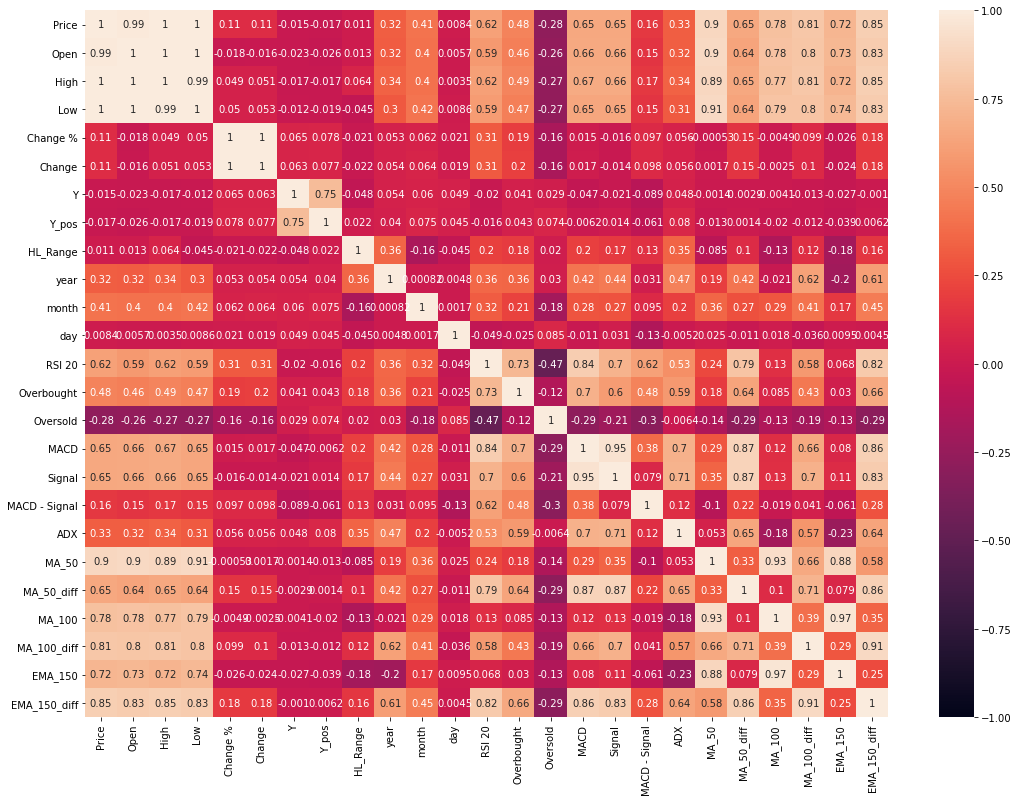

In [1115]:
f, ax = plt.subplots(figsize=(18, 13))
sns.heatmap(data.corr(),annot=True,vmin=-1, vmax=1)

In [688]:
data['Y_pos'].value_counts()

1    2360
0    2337
Name: Y_pos, dtype: int64

## Classification

### Preparing data

#### Standard Scaler

In [1268]:
columns_to_drop = ['Date','year','month','day','Y','Y_pos','Close','High','Low','Overbought','Oversold']

Xc = data.drop(columns=columns_to_drop,errors='ignore')
yc = data['Y_pos']

Xc_train_change, Xc_test_change, yc_train, yc_test = tts(Xc,yc,test_size=0.2,random_state=1123)
Xc_train_change, Xc_val_change, yc_train, yc_val = tts(Xc_train_change,yc_train,test_size=1/3,random_state=1123)

Xc_train_change = pd.DataFrame(Xc_train_change, columns = Xc.columns)
Xc_test_change  = pd.DataFrame(Xc_test_change, columns = Xc.columns)
Xc_val_change = pd.DataFrame(Xc_val_change, columns = Xc.columns)

Xc_train = Xc_train_change.drop(columns=['Change','Price'],errors='ignore')
Xc_test = Xc_test_change.drop(columns=['Change','Price'],errors='ignore')
Xc_val = Xc_val_change.drop(columns=['Change','Price'],errors='ignore')

feature_names = Xc_train.columns
scaler = StandardScaler()

scaler.fit(Xc_train)

Xc_train = scaler.transform(Xc_train)
Xc_test  = scaler.transform(Xc_test)
Xc_val  = scaler.transform(Xc_val)

Xc_train = pd.DataFrame(Xc_train, columns = feature_names)
Xc_test = pd.DataFrame(Xc_test, columns = feature_names)
Xc_val = pd.DataFrame(Xc_val, columns = feature_names)

In [1246]:
Xc2_change = data2.drop(columns=columns_to_drop,errors='ignore')
yc2 = data2['Y_pos']
Xc2 = Xc2_change.drop(columns=['Change','Price'],errors='ignore')
Xc2  = scaler.transform(Xc2)
Xc2 = pd.DataFrame(Xc2, columns = feature_names)

In [1250]:
Xc_val

,Open,Change %,HL_Range,RSI 20,MACD,Signal,MACD - Signal,ADX,MA_50,MA_50_diff,MA_100,MA_100_diff,EMA_150,EMA_150_diff
0,0.105971,2.154144,2.385619,-0.147683,-1.219937,-1.577905,1.004966,-1.230510,0.367185,-2.221049,0.433160,-0.104042,0.818044,-1.498800
1,-1.329237,-1.393256,0.413834,-0.298193,0.007504,-0.352031,1.245410,0.458875,-1.323612,-0.911154,-1.210941,-0.213018,-1.213393,-0.657669
2,0.458279,-0.050066,-0.499203,-0.142835,0.622992,0.731104,-0.254775,0.319898,0.444501,0.098047,0.464761,-0.589840,0.472911,0.023170
3,-0.135125,-0.859424,-0.021387,0.216926,0.380146,0.355177,0.159180,-0.371521,-0.247133,0.447603,-0.252486,0.221574,-0.277680,0.208082
4,0.847116,0.449326,0.350597,0.859014,1.152814,0.716536,1.730232,0.071462,0.583254,1.958586,0.535753,-0.571459,0.752985,0.429346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.684762,-0.291151,-0.980129,1.027864,1.312248,1.607109,-0.768942,1.767985,0.378181,1.915362,0.078543,1.660586,0.082338,1.578887
1249,-1.030506,-1.031628,-0.168091,-0.283086,0.128604,0.033675,0.353076,-0.666416,-1.081830,-0.071093,-1.035430,-0.344315,-1.013393,-0.336475
1250,-0.865717,-1.221052,0.213868,0.550547,0.576324,0.515147,0.322022,0.644447,-1.062100,0.659968,-1.167906,0.690303,-1.156586,0.464897
1251,-1.159577,0.363224,-0.118122,-0.086133,0.457153,0.593821,-0.385331,0.091876,-1.191659,-0.093645,-1.164023,0.375191,-1.051615,-0.369413


###### Polynomial Features

In [1292]:
columns_to_drop = ['Date','year','month','day','Y','Y_pos','Close','High','Low','Overbought','Oversold']

Xc = data.drop(columns=columns_to_drop,errors='ignore')
yc = data['Y_pos']

Xc_train_change, Xc_test_change, yc_train, yc_test = tts(Xc,yc,test_size=0.2,random_state=1123)
Xc_train_change, Xc_val_change, yc_train, yc_val = tts(Xc_train_change,yc_train,test_size=1/3,random_state=1123)

Xc_train_change = pd.DataFrame(Xc_train_change, columns = Xc.columns)
Xc_test_change  = pd.DataFrame(Xc_test_change, columns = Xc.columns)
Xc_val_change = pd.DataFrame(Xc_val_change, columns = Xc.columns)

Xc_train = Xc_train_change.drop(columns=['Change','Price'],errors='ignore')
Xc_test = Xc_test_change.drop(columns=['Change','Price'],errors='ignore')
Xc_val = Xc_val_change.drop(columns=['Change','Price'],errors='ignore')

feature_names = Xc_train.columns
scaler = StandardScaler()

scaler.fit(Xc_train)

Xc_train = scaler.transform(Xc_train)
Xc_test  = scaler.transform(Xc_test)
Xc_val  = scaler.transform(Xc_val)

Xc_train = pd.DataFrame(Xc_train, columns = feature_names)
Xc_test = pd.DataFrame(Xc_test, columns = feature_names)
Xc_val = pd.DataFrame(Xc_val, columns = feature_names)

poly = PF(2)
Xc_trainp = poly.fit_transform(Xc_train)
Xc_testp = poly.fit_transform(Xc_test)
Xc_valp = poly.fit_transform(Xc_val)

feature_namesp = poly.get_feature_names(Xc_train.columns)

Xc_trainp = pd.DataFrame(Xc_trainp, columns = feature_namesp)
Xc_testp = pd.DataFrame(Xc_testp, columns = feature_namesp)
Xc_valp = pd.DataFrame(Xc_valp, columns = feature_namesp)

In [1252]:
Xc_valp

,1,Open,Change %,HL_Range,RSI 20,MACD,Signal,MACD - Signal,ADX,MA_50,...,MA_100^2,MA_100 MA_100_diff,MA_100 EMA_150,MA_100 EMA_150_diff,MA_100_diff^2,MA_100_diff EMA_150,MA_100_diff EMA_150_diff,EMA_150^2,EMA_150 EMA_150_diff,EMA_150_diff^2
0,1.0,0.105971,2.154144,2.385619,-0.147683,-1.219937,-1.577905,1.004966,-1.230510,0.367185,...,0.187627,-0.045067,0.354344,-0.649220,0.010825,-0.085111,0.155938,0.669195,-1.226083,2.246400
1,1.0,-1.329237,-1.393256,0.413834,-0.298193,0.007504,-0.352031,1.245410,0.458875,-1.323612,...,1.466379,0.257953,1.469348,0.796399,0.045377,0.258475,0.140096,1.472323,0.798011,0.432529
2,1.0,0.458279,-0.050066,-0.499203,-0.142835,0.622992,0.731104,-0.254775,0.319898,0.444501,...,0.216003,-0.274135,0.219791,0.010768,0.347911,-0.278942,-0.013666,0.223645,0.010957,0.000537
3,1.0,-0.135125,-0.859424,-0.021387,0.216926,0.380146,0.355177,0.159180,-0.371521,-0.247133,...,0.063749,-0.055944,0.070110,-0.052538,0.049095,-0.061527,0.046105,0.077106,-0.057780,0.043298
4,1.0,0.847116,0.449326,0.350597,0.859014,1.152814,0.716536,1.730232,0.071462,0.583254,...,0.287032,-0.306161,0.403414,0.230023,0.326565,-0.430300,-0.245353,0.566986,0.323291,0.184338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,1.0,0.684762,-0.291151,-0.980129,1.027864,1.312248,1.607109,-0.768942,1.767985,0.378181,...,0.006169,0.130428,0.006467,0.124011,2.757546,0.136730,2.621877,0.006780,0.130003,2.492883
1249,1.0,-1.030506,-1.031628,-0.168091,-0.283086,0.128604,0.033675,0.353076,-0.666416,-1.081830,...,1.072115,0.356514,1.049297,0.348396,0.118553,0.348927,0.115853,1.026965,0.340981,0.113215
1250,1.0,-0.865717,-1.221052,0.213868,0.550547,0.576324,0.515147,0.322022,0.644447,-1.062100,...,1.364005,-0.806209,1.350784,-0.542956,0.476518,-0.798395,0.320920,1.337691,-0.537693,0.216129
1251,1.0,-1.159577,0.363224,-0.118122,-0.086133,0.457153,0.593821,-0.385331,0.091876,-1.191659,...,1.354950,-0.436731,1.224104,0.430005,0.140768,-0.394556,-0.138600,1.105894,0.388480,0.136466


#### Robust Scaler

In [910]:
columns_to_drop = ['Date','year','month','day','Y','Y_pos','Price','Close','High','Low','Overbought','Oversold']

Xc = data.drop(columns=columns_to_drop,errors='ignore')
yc = data['Y_pos']

Xc_train_change, Xc_test_change, yc_train, yc_test = tts(Xc,yc,test_size=0.2,random_state=1123)
Xc_train_change, Xc_val_change, yc_train, yc_val = tts(Xc_train_change,yc_train,test_size=1/3,random_state=1123)

Xc_train_change = pd.DataFrame(Xc_train_change, columns = Xc.columns)
Xc_test_change  = pd.DataFrame(Xc_test_change, columns = Xc.columns)
Xc_val_change = pd.DataFrame(Xc_val_change, columns = Xc.columns)

Xc_train = Xc_train_change.drop(columns='Change',errors='ignore')
Xc_test = Xc_test_change.drop(columns='Change',errors='ignore')
Xc_val = Xc_val_change.drop(columns='Change',errors='ignore')

feature_names = Xc_train.columns
scaler = RobustScaler()

scaler.fit(Xc_train)

Xc_train = scaler.transform(Xc_train)
Xc_test  = scaler.transform(Xc_test)
Xc_val  = scaler.transform(Xc_val)

Xc_train = pd.DataFrame(Xc_train, columns = feature_names)
Xc_test = pd.DataFrame(Xc_test, columns = feature_names)
Xc_val = pd.DataFrame(Xc_val, columns = feature_names)

### GradientBoostingClassifier() - StandardScaler

#### Basic

In [1264]:
model = GBC(random_state=1)

model.fit(Xc_train, yc_train)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model on the dataset
n_scores = cross_val_score(model, Xc_train, yc_train, scoring='accuracy', cv=cv, n_jobs=-1)



# report performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.503 (0.035)


In [1265]:
model = GBC(random_state=1)

model.fit(Xc_train, yc_train)

yc_predict = model.predict(Xc_val)
good = 0
bad = 0
for i in range(len(yc_val)):
    
    if list(yc_val)[i]==list(yc_predict)[i]:
        good += np.abs(list(Xc_val_change['Change'])[i])
    else:
        bad += np.abs(list(Xc_val_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
print('Profit: ',np.round(good-bad,3))

accuracy = sum(yc_val==yc_predict)/len(yc_val)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(yc_val,yc_predict)

print('Kappa: ',np.round(kappa,4))
profit_per = np.round(100*(good-bad)/(good+bad),1)
print('Profit/Total moved :',profit_per)

Good:  3.888
Bad:  3.241
Profit:  0.647
Accuracy:  0.522
Kappa:  0.0456
Profit/Total moved : 9.1


In [1266]:
yc_predict = model.predict(Xc_test)
good = 0
bad = 0
for i in range(len(yc_test)):
    
    if list(yc_test)[i]==list(yc_predict)[i]:
        good += np.abs(list(Xc_test_change['Change'])[i])
    else:
        bad += np.abs(list(Xc_test_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
print('Profit: ',np.round(good-bad,3))

accuracy = sum(yc_test==yc_predict)/len(yc_test)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(yc_test,yc_predict)

print('Kappa: ',np.round(kappa,4))
profit_per = np.round(100*(good-bad)/(good+bad),1)
print('Profit/Total moved :',profit_per)

Good:  2.695
Bad:  2.326
Profit:  0.37
Accuracy:  0.537
Kappa:  0.0737
Profit/Total moved : 7.4


In [1249]:
yc_predict = model.predict(Xc2)
good = 0
bad = 0
for i in range(len(yc2)):
    
    if list(yc2)[i]==list(yc_predict)[i]:
        good += np.abs(list(Xc2_change['Change'])[i])
    else:
        bad += np.abs(list(Xc2_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
print('Profit: ',np.round(good-bad,3))

accuracy = sum(yc2==yc_predict)/len(yc2)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(yc2,yc_predict)

print('Kappa: ',np.round(kappa))
profit_per = np.round(100*(good-bad)/(good+bad),1)
print('Profit/Total moved :',profit_per)

Good:  0.066
Bad:  0.082
Profit:  -0.017
Accuracy:  0.429
Kappa:  -0.0
Profit/Total moved : -11.2


#### Number of Trees

>10 0.512 (0.018)
>50 0.511 (0.024)
>100 0.508 (0.022)
>500 0.500 (0.023)
>1000 0.497 (0.023)
>5000 0.501 (0.020)


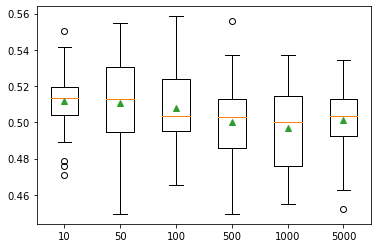

In [647]:
def get_models():     # get a list of models to evaluate
    
    models = dict()
    n_trees = [10, 50, 100, 500, 1000, 5000]     # define number of trees to consider
    for n in n_trees:
        models['N_trees:'+str(n)] = GBC(n_estimators=n)
    return models
 

def evaluate_model(model, X, y):    # evaluate a given model using cross-validation
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)   # define the evaluation procedure
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)   # evaluate the model and collect the results
    return scores
 

models = get_models()  # get the models to evaluate
results, names = list(), list()

for name, model in models.items():   # evaluate the models and store results
    
    scores = evaluate_model(model, Xc_train, yc_train) # evaluate the model
    
    results.append(scores) # store the results
    names.append(name)
    
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores))) # summarize the performance along the way
    

plt.boxplot(results, labels=names, showmeans=True)  # plot model performance for comparison
plt.show()

#### Number of Samples

>N_samples:0.1 0.502 (0.029)
>N_samples:0.2 0.506 (0.027)
>N_samples:0.30000000000000004 0.504 (0.022)
>N_samples:0.4 0.507 (0.023)
>N_samples:0.5 0.505 (0.019)
>N_samples:0.6 0.507 (0.021)
>N_samples:0.7000000000000001 0.499 (0.022)
>N_samples:0.8 0.504 (0.026)
>N_samples:0.9 0.506 (0.030)
>N_samples:1.0 0.507 (0.021)


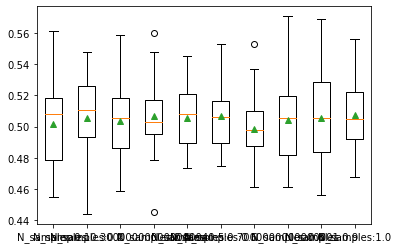

In [651]:
def get_models():     # get a list of models to evaluate
    
    models = dict()
    for i in np.arange(0.1, 1.1, 0.1):
        models['N_samples:'+str(i)] = GBC(subsample=i)
    return models

models = get_models()  # get the models to evaluate
results, names = list(), list()

for name, model in models.items():   # evaluate the models and store results
    
    scores = evaluate_model(model, Xc_train, yc_train) # evaluate the model
    
    results.append(scores) # store the results
    names.append(name)
    
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores))) # summarize the performance along the way
    

plt.boxplot(results, labels=names, showmeans=True)  # plot model performance for comparison
plt.show()

#### Number of Features

>N_feat:1 0.507 (0.021)
>N_feat:2 0.510 (0.027)
>N_feat:3 0.504 (0.026)
>N_feat:4 0.511 (0.025)
>N_feat:5 0.507 (0.024)
>N_feat:6 0.503 (0.026)
>N_feat:7 0.509 (0.022)
>N_feat:8 0.507 (0.025)
>N_feat:9 0.511 (0.021)
>N_feat:10 0.503 (0.025)
>N_feat:11 0.504 (0.024)
>N_feat:12 0.509 (0.021)
>N_feat:13 0.505 (0.024)
>N_feat:14 0.507 (0.024)
>N_feat:15 0.509 (0.021)
>N_feat:16 0.500 (0.024)
>N_feat:17 0.505 (0.022)
>N_feat:18 0.505 (0.023)
>N_feat:19 0.508 (0.022)


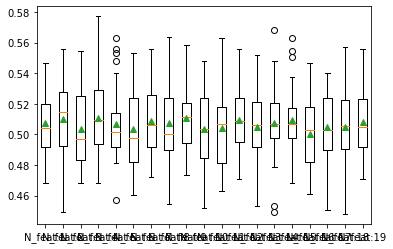

In [652]:
def get_models():     # get a list of models to evaluate
    
    models = dict()
    for j in range(1,20):
        models['N_feat:'+str(j)] = GBC(max_features=j)
    return models

models = get_models()  # get the models to evaluate
results, names = list(), list()

for name, model in models.items():   # evaluate the models and store results
    
    scores = evaluate_model(model, Xc_train, yc_train) # evaluate the model
    
    results.append(scores) # store the results
    names.append(name)
    
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores))) # summarize the performance along the way
    

plt.boxplot(results, labels=names, showmeans=True)  # plot model performance for comparison
plt.show()

#### Learning Rate

>L_rate:0.0001 0.501 (0.006)
>L_rate:0.001 0.508 (0.016)
>L_rate:0.01 0.509 (0.019)
>L_rate:0.1 0.510 (0.022)
>L_rate:1.0 0.500 (0.019)


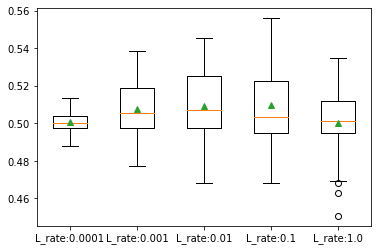

In [653]:
def get_models():     # get a list of models to evaluate
    
    models = dict()
    for k in [0.0001, 0.001, 0.01, 0.1, 1.0]:
        models['L_rate:'+str(k)] = GBC(learning_rate=k)
    return models

models = get_models()  # get the models to evaluate
results, names = list(), list()

for name, model in models.items():   # evaluate the models and store results
    
    scores = evaluate_model(model, Xc_train, yc_train) # evaluate the model
    
    results.append(scores) # store the results
    names.append(name)
    
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores))) # summarize the performance along the way
    

plt.boxplot(results, labels=names, showmeans=True)  # plot model performance for comparison
plt.show()

#### Tree Depth

>T_depth:1 0.505 (0.028)
>T_depth:2 0.506 (0.021)
>T_depth:3 0.507 (0.022)
>T_depth:4 0.504 (0.026)
>T_depth:5 0.509 (0.028)
>T_depth:6 0.507 (0.020)
>T_depth:7 0.514 (0.020)
>T_depth:8 0.510 (0.024)
>T_depth:9 0.515 (0.023)
>T_depth:10 0.510 (0.026)


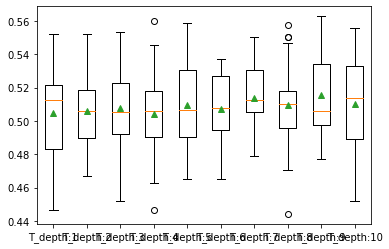

In [654]:
def get_models():     # get a list of models to evaluate
    
    models = dict()
    for l in range(1,11):
        models['T_depth:'+str(l)] = GBC(max_depth=l)
    return models

models = get_models()  # get the models to evaluate
results, names = list(), list()

for name, model in models.items():   # evaluate the models and store results
    
    scores = evaluate_model(model, Xc_train, yc_train) # evaluate the model
    
    results.append(scores) # store the results
    names.append(name)
    
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores))) # summarize the performance along the way
    

plt.boxplot(results, labels=names, showmeans=True)  # plot model performance for comparison
plt.show()

#### Grid Search

##### Test 1

In [691]:
model = GBC()

grid = dict()  # define the grid of values to search

grid['n_estimators'] = [10, 50, 100, 200]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['subsample'] = [0.1, 0.5, 0.7, 1.0]
grid['max_depth'] = [3, 5, 7, 9]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # define the evaluation procedure


grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',verbose=4)  # define the grid search procedure


grid_result = grid_search.fit(Xc_train, yc_train)  # execute the grid search


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # summarize the best score and configuration

means = grid_result.cv_results_['mean_test_score'] # summarize all scores that were evaluated
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 320 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 293 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 685 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 954 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1273 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 2057 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 2522 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 3037 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 3600 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 4213 tasks      | elapsed: 41.9min
[Parallel(n_jobs=-1)]: Done 4874 tasks      | elapsed: 46.9min
[Parallel(n_jobs=-1)]: Done 5585 tasks      | el

Best: 0.521077 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.7}
0.502262 (0.000608) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.1}
0.502262 (0.000608) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.502262 (0.000608) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.502262 (0.000608) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.502262 (0.000608) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.1}
0.502262 (0.000608) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}
0.502262 (0.000608) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
0.501464 (0.002337) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
0.502262 (0.000608) with: {'learning_rate': 0.0001, '

In [817]:
lear0_001 = 0
lear0_01 = 0
lear0_1 = 0
lear1 = 0
for mean, stdev, param in zip(means, stds, params):
    if mean>0.514:
        print("%f (%f) with: %r" % (mean, stdev, param))
        key = 'subsample'
        check = [0.1, 0.5, 0.7, 1.0]
        
        if param[key] == check[0]:
            lear0_001 += 1
        if param[key] == check[1]:
            lear0_01 += 1
        if param[key] == check[2]:
            lear0_1 += 1
        if param[key] == check[3]:
            lear1 += 1
print(lear0_001)
print(lear0_01)
print(lear0_1)
print(lear1)

# ACCURACY > 0.51

# LEARNING RATE

# 0.001 : 19
# 0.01 : 11
# 0.1 : 7 *
# 1.0 : 8

# MAX DEPTH

# 3 : 8
# 5 : 9
# 7 : 11
# 9 : 17 *

# NUMBER OF TREES

# 10 : 5
# 50 : 5
# 100 : 19 *
# 200 : 16

# NUMBER OF SAMPLES

# 0.1 : 4
# 0.5 : 13
# 0.7 : 14 *
# 1.0 : 14

# 0.521077 (0.022959) with: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.7}

0.516911 (0.024544) with: {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.5}
0.515392 (0.022819) with: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.5}
0.521077 (0.022959) with: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.7}
0.515129 (0.029675) with: {'learning_rate': 1.0, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
0
3
1
0


In [1259]:
model = GBC(learning_rate= 0.1, max_depth= 9, n_estimators= 100, subsample= 0.7,random_state=1)

model.fit(Xc_train, yc_train)

yc_predict = model.predict(Xc_test)

feature_rank = [(model.feature_importances_[i],list(Xc_test.columns)[i]) for i in range(len(Xc_test.columns))]
feature_rank.sort(reverse=True)
print(feature_rank)

[(0.10616055640737518, 'HL_Range'), (0.08829420038976109, 'Change %'), (0.08709408871082006, 'ADX'), (0.08568828596010448, 'MACD - Signal'), (0.08195847319869733, 'RSI 20'), (0.08087374429191822, 'MA_50_diff'), (0.07644045091685028, 'MA_100_diff'), (0.07128310419574488, 'EMA_150_diff'), (0.06820090561865139, 'MACD'), (0.06580523223170513, 'Signal'), (0.05812072128970547, 'Open'), (0.04598903313187488, 'MA_50'), (0.04262919383466718, 'MA_100'), (0.041462009822124245, 'EMA_150')]


In [1261]:
yc_predict = model.predict(Xc_train)
good = 0
bad = 0
for i in range(len(yc_train)):
    
    if list(yc_train)[i]==list(yc_predict)[i]:
        good += np.abs(list(Xc_train_change['Change'])[i])
    else:
        bad += np.abs(list(Xc_train_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
print('Profit: ',np.round(good-bad,3))

accuracy = sum(yc_train==yc_predict)/len(yc_train)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(yc_train,yc_predict)

print('Kappa: ',np.round(kappa,4))

Good:  13.602
Bad:  0
Profit:  13.602
Accuracy:  1.0
Kappa:  1.0


In [1262]:
yc_predict = model.predict(Xc_test)
good = 0
bad = 0
for i in range(len(yc_test)):
    
    if list(yc_test)[i]==list(yc_predict)[i]:
        good += np.abs(list(Xc_test_change['Change'])[i])
    else:
        bad += np.abs(list(Xc_test_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
print('Profit: ',np.round(good-bad,3))

accuracy = sum(yc_test==yc_predict)/len(yc_test)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(yc_test,yc_predict)

print('Kappa: ',np.round(kappa,4))

Good:  2.527
Bad:  2.494
Profit:  0.033
Accuracy:  0.518
Kappa:  0.0357


In [1215]:
yc_predict = model.predict(Xc2)
good = 0
bad = 0
for i in range(len(yc2)):
    
    if list(yc2)[i]==list(yc_predict)[i]:
        good += np.abs(list(Xc2_change['Change'])[i])
    else:
        bad += np.abs(list(Xc2_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
print('Profit: ',np.round(good-bad,3))

accuracy = sum(yc2==yc_predict)/len(yc2)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(yc2,yc_predict)

print('Kappa: ',np.round(kappa))
profit_per = np.round(100*(good-bad)/(good+bad),1)
print('Profit/Total moved :',profit_per)

Good:  0.076
Bad:  0.072
Profit:  0.004
Accuracy:  0.524
Kappa:  0.0
Profit/Total moved : 3.0


##### RFE

In [1255]:
nof_list=np.arange(1,120)    #no of features        
high_score=0

nof=0           #Variable to store the optimum features 
score_list =[]

for n in range(len(nof_list)):
    
    model = GBC(random_state=1)
    rfe = RFE(model,n_features_to_select=nof_list[n])
    Xc_train_rfe = rfe.fit_transform(Xc_trainp,yc_train)
    Xc_test_rfe = rfe.transform(Xc_testp)
    model.fit(Xc_train_rfe,yc_train)
    score = model.score(Xc_test_rfe,yc_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

KeyboardInterrupt: 

In [806]:
nof_list=np.arange(1,16)    #no of features        
high_score=0

nof=0           #Variable to store the optimum features 
score_list =[]

for n in range(len(nof_list)):
    
    model = GBC(learning_rate= 0.1, max_depth= 9, n_estimators= 100, subsample= 0.7,random_state=1)
    rfe = RFE(model,n_features_to_select=nof_list[n])
    Xc_train_rfe = rfe.fit_transform(Xc_train,yc_train)
    Xc_test_rfe = rfe.transform(Xc_test)
    model.fit(Xc_train_rfe,yc_train)
    score = model.score(Xc_test_rfe,yc_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 14
Score with 14 features: 0.520213


In [811]:
model = GBC(learning_rate= 0.1, max_depth= 9, n_estimators= 100, subsample= 0.7,random_state=1)
#Initializing RFE model
rfe = RFE(model,n_features_to_select=14)
#Transforming data using RFE
Xc_rfe = rfe.fit_transform(Xc_train,yc_train)  
#Fitting the data to model
model.fit(Xc_rfe,yc_train)
print(rfe.support_)
print(rfe.ranking_)

feature_rank = [(rfe.ranking_[i],list(Xc_test.columns)[i]) for i in range(len(Xc_test.columns))]
feature_rank.sort()
print(feature_rank)

[ True  True  True  True False False  True  True  True  True  True  True
  True  True  True  True]
[1 1 1 1 3 2 1 1 1 1 1 1 1 1 1 1]
[(1, 'ADX'), (1, 'Change %'), (1, 'EMA_150'), (1, 'EMA_150_diff'), (1, 'HL_Range'), (1, 'MACD'), (1, 'MACD - Signal'), (1, 'MA_100'), (1, 'MA_100_diff'), (1, 'MA_50'), (1, 'MA_50_diff'), (1, 'Open'), (1, 'RSI 20'), (1, 'Signal'), (2, 'Oversold'), (3, 'Overbought')]


##### Test 2

In [818]:
model = GBC()

grid = dict()  # define the grid of values to search

grid['n_estimators'] = [80,100,130,160]
grid['learning_rate'] = [0.001, 0.01, 0.1, 1.0]
grid['subsample'] = [0.5,0.6,0.7,0.8]
grid['max_depth'] = [7,9,11,13]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # define the evaluation procedure


grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',verbose=2)  # define the grid search procedure


grid_result = grid_search.fit(Xc_train, yc_train)  # execute the grid search


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # summarize the best score and configuration

means = grid_result.cv_results_['mean_test_score'] # summarize all scores that were evaluated
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 256 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 51.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 63.2min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 83.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 112.7min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 130.1min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 164.4min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 194.4min
[Parallel(n_jobs=-1)]: Done 7680 out of 7680 | elapsed: 216.5min finished


Best: 0.522584 using {'learning_rate': 0.1, 'max_depth': 13, 'n_estimators': 130, 'subsample': 0.5}
0.511849 (0.020931) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 80, 'subsample': 0.5}
0.506701 (0.018464) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 80, 'subsample': 0.6}
0.510961 (0.020561) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 80, 'subsample': 0.7}
0.512291 (0.019239) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 80, 'subsample': 0.8}
0.508919 (0.021736) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.5}
0.513620 (0.021598) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.6}
0.509007 (0.019964) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}
0.513350 (0.020138) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
0.506343 (0.020463) with: {'learning_rate': 0.001, 'max_

In [826]:
lear0_001 = 0
lear0_01 = 0
lear0_1 = 0
lear1 = 0
for mean, stdev, param in zip(means, stds, params):
    if mean>0.517:
        print("%f (%f) with: %r" % (mean, stdev, param))
        key = 'max_depth'
        
        if param[key] == grid[key][0]:
            lear0_001 += 1
        if param[key] == grid[key][1]:
            lear0_01 += 1
        if param[key] == grid[key][2]:
            lear0_1 += 1
        if param[key] == grid[key][3]:
            lear1 += 1
print(lear0_001)
print(lear0_01)
print(lear0_1)
print(lear1)

0.518504 (0.024226) with: {'learning_rate': 0.001, 'max_depth': 11, 'n_estimators': 100, 'subsample': 0.6}
0.519473 (0.018261) with: {'learning_rate': 0.001, 'max_depth': 13, 'n_estimators': 80, 'subsample': 0.5}
0.520184 (0.023744) with: {'learning_rate': 0.001, 'max_depth': 13, 'n_estimators': 80, 'subsample': 0.7}
0.517971 (0.028854) with: {'learning_rate': 0.001, 'max_depth': 13, 'n_estimators': 160, 'subsample': 0.8}
0.517966 (0.021856) with: {'learning_rate': 0.01, 'max_depth': 11, 'n_estimators': 100, 'subsample': 0.5}
0.518853 (0.023649) with: {'learning_rate': 0.01, 'max_depth': 11, 'n_estimators': 130, 'subsample': 0.7}
0.519477 (0.022022) with: {'learning_rate': 0.01, 'max_depth': 13, 'n_estimators': 80, 'subsample': 0.7}
0.519477 (0.023263) with: {'learning_rate': 0.01, 'max_depth': 13, 'n_estimators': 100, 'subsample': 0.5}
0.517970 (0.020723) with: {'learning_rate': 0.01, 'max_depth': 13, 'n_estimators': 160, 'subsample': 0.5}
0.519481 (0.021742) with: {'learning_rate': 0

In [1271]:
model = GBC(learning_rate= 0.1, max_depth= 13, n_estimators= 130, subsample= 0.5,random_state=1)

model.fit(Xc_train, yc_train)

feature_rank = [(model.feature_importances_[i],list(Xc_test.columns)[i]) for i in range(len(Xc_test.columns))]
feature_rank.sort(reverse=True)
print(feature_rank)

[(0.10992685227466799, 'HL_Range'), (0.09538003649398877, 'Change %'), (0.08564340208960067, 'ADX'), (0.08164183477017721, 'MACD - Signal'), (0.08048595001833447, 'MA_100_diff'), (0.07707116087113604, 'MA_50_diff'), (0.07622477990236542, 'RSI 20'), (0.07321850188895183, 'EMA_150_diff'), (0.06620886401630204, 'MACD'), (0.06192256928773852, 'Signal'), (0.05749585293782474, 'Open'), (0.04737113709159646, 'MA_50'), (0.04673977518816756, 'MA_100'), (0.040669283169148314, 'EMA_150')]


In [1145]:
train = []
val = []
rang = list(range(1,10,1))
for i in rang:
    print('n_estimators: ',i)
    model = GBC(learning_rate= 0.1, max_depth= 5, n_estimators=i, subsample= 0.5,random_state=1)

    model.fit(Xc_train, yc_train)
    yc_predict = model.predict(Xc_train)
    yc_predict_val = model.predict(Xc_val)
    good = 0
    bad = 0
    for i in range(len(yc_train)):

        if list(yc_train)[i]==list(yc_predict)[i]:
            good += np.abs(list(Xc_train_change['Change'])[i])
        else:
            bad += np.abs(list(Xc_train_change['Change'])[i])
    #print('Good: ',np.round(good,3))
    #print('Bad: ',np.round(bad,3))
    print('Profit: ',np.round(good-bad,3))

    #accuracy = sum(yc_train==yc_predict)/len(yc_train)
    accuracy = accuracy_score(yc_train,yc_predict)
    accuracy_val = accuracy_score(yc_val,yc_predict_val)
    train.append(accuracy)
    val.append(accuracy_val)
    print('Accuracy: ',np.round(accuracy,3))
    print('Accuracy_val: ',np.round(accuracy_val,3))
    print('\n')

    kappa = cohen_kappa_score(yc_train,yc_predict)

    #print('Kappa: ',np.round(kappa,4))

n_estimators:  1
Profit:  0.254
Accuracy:  0.647
Accuracy_val:  0.5


n_estimators:  2
Profit:  0.451
Accuracy:  0.755
Accuracy_val:  0.514


n_estimators:  3
Profit:  0.552
Accuracy:  0.777
Accuracy_val:  0.493


n_estimators:  4
Profit:  0.549
Accuracy:  0.795
Accuracy_val:  0.486


n_estimators:  5
Profit:  0.578
Accuracy:  0.813
Accuracy_val:  0.464


n_estimators:  6
Profit:  0.604
Accuracy:  0.824
Accuracy_val:  0.464


n_estimators:  7
Profit:  0.728
Accuracy:  0.863
Accuracy_val:  0.5


n_estimators:  8
Profit:  0.717
Accuracy:  0.863
Accuracy_val:  0.493


n_estimators:  9
Profit:  0.697
Accuracy:  0.86
Accuracy_val:  0.543




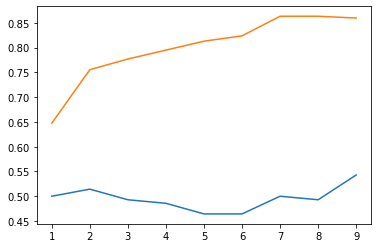

In [1146]:
plt.plot(rang,val)
plt.plot(rang,train)

In [1272]:
yc_predict = model.predict(Xc_train)
good = 0
bad = 0
for i in range(len(yc_train)):
    
    if list(yc_train)[i]==list(yc_predict)[i]:
        good += np.abs(list(Xc_train_change['Change'])[i])
    else:
        bad += np.abs(list(Xc_train_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
print('Profit: ',np.round(good-bad,3))

accuracy = sum(yc_train==yc_predict)/len(yc_train)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(yc_train,yc_predict)

print('Kappa: ',np.round(kappa,4))

Good:  13.602
Bad:  0
Profit:  13.602
Accuracy:  1.0
Kappa:  1.0


In [1280]:
yc_predict = model.predict(Xc_test)
good = 0
bad = 0
for i in range(len(yc_test)):
    
    if list(yc_test)[i]==list(yc_predict)[i]:
        good += np.abs(list(Xc_test_change['Change'])[i])
    else:
        bad += np.abs(list(Xc_test_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
print('Profit: ',np.round(good-bad,3))

#accuracy = sum(yc_train==yc_predict)/len(yc_train)
accuracy = accuracy_score(yc_test,yc_predict)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(yc_test,yc_predict)

print('Kappa: ',np.round(kappa,4))

Good:  2.501
Bad:  2.52
Profit:  -0.019
Accuracy:  0.514
Kappa:  0.0274


In [1218]:
yc_predict = model.predict(Xc2)
good = 0
bad = 0
for i in range(len(yc2)):
    
    if list(yc2)[i]==list(yc_predict)[i]:
        good += np.abs(list(Xc2_change['Change'])[i])
    else:
        bad += np.abs(list(Xc2_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
print('Profit: ',np.round(good-bad,3))

accuracy = sum(yc2==yc_predict)/len(yc2)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(yc2,yc_predict)

print('Kappa: ',np.round(kappa))
profit_per = np.round(100*(good-bad)/(good+bad),1)
print('Profit/Total moved :',profit_per)

Good:  0.081
Bad:  0.067
Profit:  0.014
Accuracy:  0.548
Kappa:  0.0
Profit/Total moved : 9.7


##### Optimal Probability

In [1274]:
model = GBC(learning_rate= 0.1, max_depth= 13, n_estimators= 130, subsample= 0.5,random_state=1)

model.fit(Xc_train, yc_train)

GradientBoostingClassifier(max_depth=13, n_estimators=130, random_state=1,
                           subsample=0.5)

MIN PROBABILITY:  50
Good:  3.459
Bad:  3.67
Profit:  -0.212
Accuracy:  0.492
616
1253


MIN PROBABILITY:  52
Good:  3.317
Bad:  3.579
Profit:  -0.262
Accuracy:  0.493
594
1206


MIN PROBABILITY:  54
Good:  3.216
Bad:  3.46
Profit:  -0.244
Accuracy:  0.495
579
1169


MIN PROBABILITY:  56
Good:  3.102
Bad:  3.308
Profit:  -0.206
Accuracy:  0.496
554
1117


MIN PROBABILITY:  58
Good:  3.026
Bad:  3.181
Profit:  -0.155
Accuracy:  0.497
536
1079


MIN PROBABILITY:  60
Good:  2.882
Bad:  3.089
Profit:  -0.208
Accuracy:  0.493
513
1041


MIN PROBABILITY:  62
Good:  2.776
Bad:  2.892
Profit:  -0.116
Accuracy:  0.501
500
999


MIN PROBABILITY:  64
Good:  2.615
Bad:  2.742
Profit:  -0.127
Accuracy:  0.495
469
947


MIN PROBABILITY:  66
Good:  2.491
Bad:  2.694
Profit:  -0.204
Accuracy:  0.489
444
908


MIN PROBABILITY:  68
Good:  2.358
Bad:  2.528
Profit:  -0.17
Accuracy:  0.494
425
861


MIN PROBABILITY:  70
Good:  2.239
Bad:  2.398
Profit:  -0.159
Accuracy:  0.491
403
820


MIN PROBABILITY:  

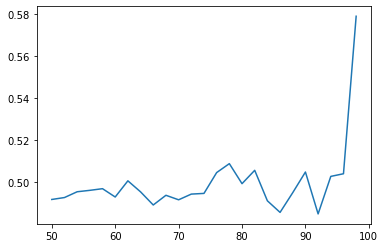

In [1277]:
proba = model.predict_proba(Xc_val)

yc_predict_val = model.predict(Xc_val)
min_probs = list(range(50,100,2))
prof = []
acc = []
for min_prob in min_probs:
    print('MIN PROBABILITY: ',min_prob)
    good = 0
    bad = 0
    ig = 0
    ib = 0
    for i in range(len(yc_val)):
        
        if max(proba[i])>min_prob/100:
            if list(yc_val)[i]==list(yc_predict_val)[i]:
                ig +=1
                good += np.abs(list(Xc_val_change['Change'])[i])
            else:
                ib +=1
                bad += np.abs(list(Xc_val_change['Change'])[i])
    print('Good: ',np.round(good,3))
    print('Bad: ',np.round(bad,3))
    profit = np.round(good-bad,3)
    prof.append(profit)
    print('Profit: ',profit)

    accuracy = ig/(ig+ib)
    acc.append(accuracy)
    print('Accuracy: ',np.round(accuracy,3))
    print(ig)
    print(ig+ib)
    
    kappa = cohen_kappa_score(yc_val,yc_predict_val)

    #print('Kappa: ',np.round(kappa,4))
    print('\n')

plt.plot(min_probs,acc)

In [1282]:
proba = model.predict_proba(Xc_test)

yc_predict = model.predict(Xc_test)
good = 0
bad = 0
ii=0
ig = 0
ib = 0
goodie = []
predictie = []
for i in range(len(yc_test)):

    if max(proba[i])>0.98:
        ii +=1
        goodie.append(list(yc_test)[i])
        predictie.append(list(yc_predict)[i])
        if list(yc_test)[i]==list(yc_predict)[i]:
            ig +=1
            good += np.abs(list(Xc_test_change['Change'])[i])
            
        else:
            ib +=1
            bad += np.abs(list(Xc_test_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
profit = np.round(good-bad,3)
print('Profit: ',profit)

accuracy = ig/(ig+ib)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(goodie,predictie)

print('Kappa: ',np.round(kappa,4))
print(ii)

Good:  0.094
Bad:  0.036
Profit:  0.058
Accuracy:  0.583
Kappa:  0.1667
24


In [1291]:
24/(len(yc_test)/261)

6.663829787234042

In [1284]:
len(data[data['year']==2010])

261

##### Test 3

In [1152]:
model = GBC(learning_rate= 0.1, max_depth= 5, n_estimators= 5, subsample= 0.5,random_state=1)

model.fit(Xc_train, yc_train)

GradientBoostingClassifier(max_depth=5, n_estimators=5, random_state=1,
                           subsample=0.5)

MIN PROBABILITY:  50
Good:  186.879
Bad:  226.116
Profit:  -39.237
Accuracy:  0.464
#: 140
%: 1.0


MIN PROBABILITY:  51
Good:  171.201
Bad:  216.597
Profit:  -45.396
Accuracy:  0.458
#: 131
%: 0.9357142857142857


MIN PROBABILITY:  52
Good:  161.064
Bad:  198.23
Profit:  -37.166
Accuracy:  0.482
#: 114
%: 0.8142857142857143


MIN PROBABILITY:  53
Good:  149.256
Bad:  157.273
Profit:  -8.018
Accuracy:  0.495
#: 103
%: 0.7357142857142858


MIN PROBABILITY:  54
Good:  126.336
Bad:  144.452
Profit:  -18.116
Accuracy:  0.495
#: 95
%: 0.6785714285714286


MIN PROBABILITY:  55
Good:  101.86
Bad:  116.686
Profit:  -14.826
Accuracy:  0.474
#: 78
%: 0.5571428571428572


MIN PROBABILITY:  56
Good:  91.816
Bad:  89.569
Profit:  2.246
Accuracy:  0.492
#: 65
%: 0.4642857142857143


MIN PROBABILITY:  57
Good:  75.22
Bad:  80.021
Profit:  -4.801
Accuracy:  0.51
#: 51
%: 0.36428571428571427


MIN PROBABILITY:  58
Good:  71.588
Bad:  65.515
Profit:  6.073
Accuracy:  0.522
#: 46
%: 0.32857142857142857



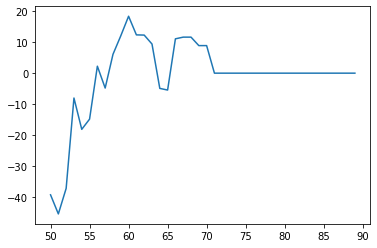

In [1154]:
proba = model.predict_proba(Xc_val)

yc_predict_val = model.predict(Xc_val)
min_probs = list(range(50,90,1))
prof = []
acc = []
for min_prob in min_probs:
    print('MIN PROBABILITY: ',min_prob)
    good = 0
    bad = 0
    ig = 0
    ib = 0
    for i in range(len(yc_val)):
        
        if max(proba[i])>min_prob/100:
            if list(yc_val)[i]==list(yc_predict_val)[i]:
                ig +=1
                #good += np.abs(list(Xc_val_change['Change'])[i])
                good += (0.0001/list(Xc_val_change['Price'])[i])*1000*np.abs(list(Xc_val_change['Change'])[i])*10000
            else:
                ib +=1
                #bad += np.abs(list(Xc_val_change['Change'])[i])
                bad += (0.0001/list(Xc_val_change['Price'])[i])*1000*np.abs(list(Xc_val_change['Change'])[i])*10000
    print('Good: ',np.round(good,3))
    print('Bad: ',np.round(bad,3))
    if (ig+ib)!=0:
        #profit = np.round((good-bad)/(ig+ib),3)
        profit = np.round((good-bad),3)
        #accuracy = accuracy_score(yc_val,yc_predict_val)
        accuracy = ig/(ig+ib)

    else:
        profit = 0
        accuracy = 0
    
    prof.append(profit)
    print('Profit: ',profit)
    acc.append(accuracy)
    print('Accuracy: ',np.round(accuracy,3))
    print('#:',ig+ib)
    print('%:',(ig+ib)/len(yc_val))
    
    kappa = cohen_kappa_score(yc_val,yc_predict_val)

    #print('Kappa: ',np.round(kappa,4))
    print('\n')

plt.plot(min_probs,prof)

In [1156]:
proba = model.predict_proba(Xc_test)

yc_predict = model.predict(Xc_test)
good = 0
bad = 0
ii = 0
for i in range(len(yc_test)):

    if max(proba[i])>0.6:
        ii +=1
        if list(yc_test)[i]==list(yc_predict)[i]:
            #good += np.abs(list(Xc_test_change['Change'])[i])
            good += (0.0001/list(Xc_test_change['Price'])[i])*1000*np.abs(list(Xc_test_change['Change'])[i])*10000
        else:
            bad += (0.0001/list(Xc_test_change['Price'])[i])*1000*np.abs(list(Xc_test_change['Change'])[i])*10000
            #bad += np.abs(list(Xc_test_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
profit = np.round(good-bad,3)
print('Profit: ',profit)

accuracy = accuracy_score(yc_test,yc_predict)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(yc_test,yc_predict)

print('Kappa: ',np.round(kappa,4))
print(ii)

Good:  69.584
Bad:  62.49
Profit:  7.094
Accuracy:  0.514
Kappa:  0.0346
34


In [959]:
ii

8

##### Poly

In [1293]:
model = GBC(learning_rate= 0.1, max_depth=7 , n_estimators= 8, subsample= 0.5,random_state=1)

model.fit(Xc_trainp, yc_train)

GradientBoostingClassifier(max_depth=7, n_estimators=8, random_state=1,
                           subsample=0.5)

In [1294]:
yc_predict = model.predict(Xc_trainp)
yc_predict_val = model.predict(Xc_valp)
good = 0
bad = 0

for i in range(len(yc_train)):

    if list(yc_train)[i]==list(yc_predict)[i]:
        good += np.abs(list(Xc_train_change['Change'])[i])
    else:
        bad += np.abs(list(Xc_train_change['Change'])[i])
#print('Good: ',np.round(good,3))
#print('Bad: ',np.round(bad,3))
print('Profit: ',np.round(good-bad,3))

#accuracy = sum(yc_train==yc_predict)/len(yc_train)
accuracy = accuracy_score(yc_train,yc_predict)
accuracy_val = accuracy_score(yc_val,yc_predict_val)
print('Accuracy: ',np.round(accuracy,3))
print('Accuracy_val: ',np.round(accuracy_val,3))
print('\n')

Profit:  7.037
Accuracy:  0.745
Accuracy_val:  0.508




MIN PROBABILITY:  50
Good:  2807.918
Bad:  2871.172
Profit:  -63.253
Accuracy:  0.508
#: 1253
%: 1.0


MIN PROBABILITY:  51
Good:  2519.29
Bad:  2642.21
Profit:  -122.92
Accuracy:  0.506
#: 1113
%: 0.888268156424581


MIN PROBABILITY:  52
Good:  2283.598
Bad:  2333.576
Profit:  -49.979
Accuracy:  0.511
#: 982
%: 0.7837190742218675


MIN PROBABILITY:  53
Good:  2084.414
Bad:  2049.291
Profit:  35.124
Accuracy:  0.514
#: 854
%: 0.6815642458100558


MIN PROBABILITY:  54
Good:  1748.261
Bad:  1799.517
Profit:  -51.257
Accuracy:  0.504
#: 724
%: 0.5778132482043097


MIN PROBABILITY:  55
Good:  1548.693
Bad:  1557.504
Profit:  -8.811
Accuracy:  0.512
#: 604
%: 0.48204309656823624


MIN PROBABILITY:  56
Good:  1258.098
Bad:  1363.522
Profit:  -105.424
Accuracy:  0.506
#: 486
%: 0.38786911412609737


MIN PROBABILITY:  57
Good:  1010.987
Bad:  1128.789
Profit:  -117.802
Accuracy:  0.51
#: 394
%: 0.31444533120510776


MIN PROBABILITY:  58
Good:  853.977
Bad:  986.771
Profit:  -132.794
Accuracy: 

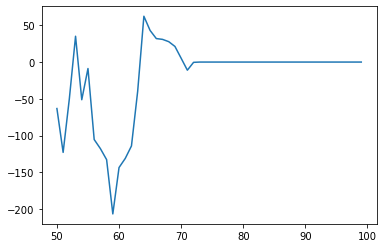

In [1295]:
proba = model.predict_proba(Xc_valp)

yc_predict_val = model.predict(Xc_valp)
min_probs = list(range(50,100,1))
prof = []
acc = []
for min_prob in min_probs:
    print('MIN PROBABILITY: ',min_prob)
    good = 0
    bad = 0
    ig = 0
    ib = 0
    for i in range(len(yc_val)):
        
        if max(proba[i])>min_prob/100:
            if list(yc_val)[i]==list(yc_predict_val)[i]:
                ig +=1
                #good += np.abs(list(Xc_val_change['Change'])[i])
                good += (0.0001/list(Xc_val_change['Price'])[i])*1000*np.abs(list(Xc_val_change['Change'])[i])*10000
            else:
                ib +=1
                #bad += np.abs(list(Xc_val_change['Change'])[i])
                bad += (0.0001/list(Xc_val_change['Price'])[i])*1000*np.abs(list(Xc_val_change['Change'])[i])*10000
    print('Good: ',np.round(good,3))
    print('Bad: ',np.round(bad,3))
    if (ig+ib)!=0:
        #profit = np.round((good-bad)/(ig+ib),3)
        profit = np.round((good-bad),3)
        #accuracy = accuracy_score(yc_val,yc_predict_val)
        accuracy = ig/(ig+ib)

    else:
        profit = 0
        accuracy = 0
    
    prof.append(profit)
    print('Profit: ',profit)
    acc.append(accuracy)
    print('Accuracy: ',np.round(accuracy,3))
    print('#:',ig+ib)
    print('%:',(ig+ib)/len(yc_val))
    
    kappa = cohen_kappa_score(yc_val,yc_predict_val)

    #print('Kappa: ',np.round(kappa,4))
    print('\n')

plt.plot(min_probs,prof)

In [1296]:
proba = model.predict_proba(Xc_testp)

yc_predict = model.predict(Xc_testp)
good = 0
bad = 0
ii = 0
for i in range(len(yc_test)):

    if max(proba[i])>0.5:
        ii +=1
        if list(yc_test)[i]==list(yc_predict)[i]:
            #good += np.abs(list(Xc_test_change['Change'])[i])
            good += (0.0001/list(Xc_test_change['Price'])[i])*1000*np.abs(list(Xc_test_change['Change'])[i])*10000
        else:
            bad += (0.0001/list(Xc_test_change['Price'])[i])*1000*np.abs(list(Xc_test_change['Change'])[i])*10000
            #bad += np.abs(list(Xc_test_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
profit = np.round(good-bad,3)
print('Profit: ',profit)

accuracy = accuracy_score(yc_test,yc_predict)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(yc_test,yc_predict)

print('Kappa: ',np.round(kappa,4))
print(ii)

Good:  1985.771
Bad:  2003.299
Profit:  -17.528
Accuracy:  0.497
Kappa:  -0.0076
940


### GradientBoostingClassifier() - RobustScaler

#### Test 2

In [911]:
model = GBC(learning_rate= 0.1, max_depth= 13, n_estimators= 130, subsample= 0.5,random_state=1)

model.fit(Xc_train, yc_train)

yc_predict = model.predict(Xc_test)
good = 0
bad = 0
for i in range(len(yc_test)):
    
    if list(yc_test)[i]==list(yc_predict)[i]:
        good += np.abs(list(Xc_test_change['Change'])[i])
    else:
        bad += np.abs(list(Xc_test_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
print('Profit: ',np.round(good-bad,3))

#accuracy = sum(yc_train==yc_predict)/len(yc_train)
accuracy = accuracy_score(yc_test,yc_predict)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(yc_test,yc_predict)

print('Kappa: ',np.round(kappa,4))

Good:  2.327
Bad:  2.694
Profit:  -0.367
Accuracy:  0.496
Kappa:  -0.0086


#### Optimal Probability

MIN PROBABILITY:  50
Good:  3.727
Bad:  3.402
Profit:  0.00026
Accuracy:  0.508


MIN PROBABILITY:  51
Good:  3.708
Bad:  3.353
Profit:  0.00029
Accuracy:  0.51


MIN PROBABILITY:  52
Good:  3.652
Bad:  3.326
Profit:  0.00027
Accuracy:  0.508


MIN PROBABILITY:  53
Good:  3.598
Bad:  3.292
Profit:  0.00025
Accuracy:  0.509


MIN PROBABILITY:  54
Good:  3.533
Bad:  3.242
Profit:  0.00024
Accuracy:  0.508


MIN PROBABILITY:  55
Good:  3.49
Bad:  3.183
Profit:  0.00026
Accuracy:  0.509


MIN PROBABILITY:  56
Good:  3.45
Bad:  3.116
Profit:  0.00029
Accuracy:  0.51


MIN PROBABILITY:  57
Good:  3.402
Bad:  3.041
Profit:  0.00032
Accuracy:  0.509


MIN PROBABILITY:  58
Good:  3.306
Bad:  2.971
Profit:  0.0003
Accuracy:  0.508


MIN PROBABILITY:  59
Good:  3.172
Bad:  2.898
Profit:  0.00025
Accuracy:  0.506


MIN PROBABILITY:  60
Good:  3.075
Bad:  2.843
Profit:  0.00022
Accuracy:  0.505


MIN PROBABILITY:  61
Good:  3.024
Bad:  2.774
Profit:  0.00024
Accuracy:  0.507


MIN PROBABILITY:  62


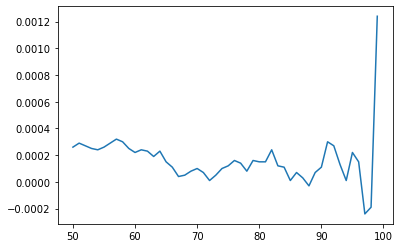

In [939]:
proba = model.predict_proba(Xc_val)

yc_predict_val = model.predict(Xc_val)
min_probs = list(range(50,100,1))
prof = []
for min_prob in min_probs:
    print('MIN PROBABILITY: ',min_prob)
    good = 0
    bad = 0
    ig = 0
    ib = 0
    for i in range(len(yc_val)):
        
        if max(proba[i])>min_prob/100:
            if list(yc_val)[i]==list(yc_predict_val)[i]:
                ig += 1
                good += np.abs(list(Xc_val_change['Change'])[i])
            else:
                ib += 1
                bad += np.abs(list(Xc_val_change['Change'])[i])
    print('Good: ',np.round(good,3))
    print('Bad: ',np.round(bad,3))
    profit = np.round((good-bad)/(ig+ib),5)
    prof.append(profit)
    print('Profit: ',profit)

    accuracy = ig/(ig+ib)
    print('Accuracy: ',np.round(accuracy,3))
    
    kappa = cohen_kappa_score(yc_val,yc_predict_val)

    #print('Kappa: ',np.round(kappa,4))
    print('\n')

plt.plot(min_probs,prof)

In [941]:
ig+ib

18

In [922]:
proba = model.predict_proba(Xc_test)

yc_predict = model.predict(Xc_test)
good = 0
bad = 0
ig = 0
ib = 0
for i in range(len(yc_test)):

    if max(proba[i])>0.99:
        if list(yc_test)[i]==list(yc_predict)[i]:
            ig += 1
            good += np.abs(list(Xc_test_change['Change'])[i])
        else:
            ib += 1
            bad += np.abs(list(Xc_test_change['Change'])[i])
print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
profit = np.round(good-bad,3)
print('Profit: ',profit)

#accuracy = accuracy_score(yc_test,yc_predict)
accuracy = ig/(ig+ib)
print('Accuracy: ',np.round(accuracy,3))

kappa = cohen_kappa_score(yc_test,yc_predict)

print('Kappa: ',np.round(kappa,4))

Good:  0.008
Bad:  0.005
Profit:  0.003
Accuracy:  0.6
Kappa:  -0.0086


## Regression

### Preparing data

In [1297]:
columns_to_drop = ['Date','year','month','day','Y','Y_pos','Close','High','Low','Overbought','Oversold']

Xc = data.drop(columns=columns_to_drop,errors='ignore')
yc = data['Y']

Xc_train_change, Xc_test_change, yc_train, yc_test = tts(Xc,yc,test_size=0.2,random_state=1123)
Xc_train_change, Xc_val_change, yc_train, yc_val = tts(Xc_train_change,yc_train,test_size=1/3,random_state=1123)

Xc_train_change = pd.DataFrame(Xc_train_change, columns = Xc.columns)
Xc_test_change  = pd.DataFrame(Xc_test_change, columns = Xc.columns)
Xc_val_change = pd.DataFrame(Xc_val_change, columns = Xc.columns)

Xc_train = Xc_train_change.drop(columns=['Change','Price'],errors='ignore')
Xc_test = Xc_test_change.drop(columns=['Change','Price'],errors='ignore')
Xc_val = Xc_val_change.drop(columns=['Change','Price'],errors='ignore')

feature_names = Xc_train.columns
scaler = StandardScaler()

scaler.fit(Xc_train)

Xc_train = scaler.transform(Xc_train)
Xc_test  = scaler.transform(Xc_test)
Xc_val  = scaler.transform(Xc_val)

Xc_train = pd.DataFrame(Xc_train, columns = feature_names)
Xc_test = pd.DataFrame(Xc_test, columns = feature_names)
Xc_val = pd.DataFrame(Xc_val, columns = feature_names)

#### StandardScaler&Poly

In [1158]:
columns_to_drop = ['Date','year','month','day','Y','Y_pos','Close','High','Low','Overbought','Oversold','EMA_150','MA_50','MA_100']

Xc = data.drop(columns=columns_to_drop,errors='ignore')
yc = data['Y']

Xc_train_change, Xc_test_change, yc_train, yc_test = tts(Xc,yc,test_size=0.2,random_state=1123)
Xc_train_change, Xc_val_change, yc_train, yc_val = tts(Xc_train_change,yc_train,test_size=1/3,random_state=1123)

Xc_train_change = pd.DataFrame(Xc_train_change, columns = Xc.columns)
Xc_test_change  = pd.DataFrame(Xc_test_change, columns = Xc.columns)
Xc_val_change = pd.DataFrame(Xc_val_change, columns = Xc.columns)

Xc_train = Xc_train_change.drop(columns=['Change','Price'],errors='ignore')
Xc_test = Xc_test_change.drop(columns=['Change','Price'],errors='ignore')
Xc_val = Xc_val_change.drop(columns=['Change','Price'],errors='ignore')

feature_names = Xc_train.columns
scaler = StandardScaler()

scaler.fit(Xc_train)

Xc_train = scaler.transform(Xc_train)
Xc_test  = scaler.transform(Xc_test)
Xc_val  = scaler.transform(Xc_val)

Xc_train = pd.DataFrame(Xc_train, columns = feature_names)
Xc_test = pd.DataFrame(Xc_test, columns = feature_names)
Xc_val = pd.DataFrame(Xc_val, columns = feature_names)

poly = PF(2)
Xc_trainp = poly.fit_transform(Xc_train)
Xc_testp = poly.fit_transform(Xc_test)
Xc_valp = poly.fit_transform(Xc_val)

feature_namesp = poly.get_feature_names(Xc_train.columns)

Xc_trainp = pd.DataFrame(Xc_trainp, columns = feature_namesp)
Xc_testp = pd.DataFrame(Xc_testp, columns = feature_namesp)
Xc_valp = pd.DataFrame(Xc_valp, columns = feature_namesp)

#### RobustScaler&Poly

In [1035]:
columns_to_drop = ['Date','year','month','day','Y','Y_pos','Close','High','Low','Overbought','Oversold']

Xc = data.drop(columns=columns_to_drop,errors='ignore')
yc = data['Y']

Xc_train_change, Xc_test_change, yc_train, yc_test = tts(Xc,yc,test_size=0.2,random_state=1123)
Xc_train_change, Xc_val_change, yc_train, yc_val = tts(Xc_train_change,yc_train,test_size=1/3,random_state=1123)

Xc_train_change = pd.DataFrame(Xc_train_change, columns = Xc.columns)
Xc_test_change  = pd.DataFrame(Xc_test_change, columns = Xc.columns)
Xc_val_change = pd.DataFrame(Xc_val_change, columns = Xc.columns)

Xc_train = Xc_train_change.drop(columns=['Change','Price'],errors='ignore')
Xc_test = Xc_test_change.drop(columns=['Change','Price'],errors='ignore')
Xc_val = Xc_val_change.drop(columns=['Change','Price'],errors='ignore')

feature_names = Xc_train.columns
scaler = RobustScaler()

scaler.fit(Xc_train)

Xc_train = scaler.transform(Xc_train)
Xc_test  = scaler.transform(Xc_test)
Xc_val  = scaler.transform(Xc_val)

Xc_train = pd.DataFrame(Xc_train, columns = feature_names)
Xc_test = pd.DataFrame(Xc_test, columns = feature_names)
Xc_val = pd.DataFrame(Xc_val, columns = feature_names)

poly = PF(2)
Xc_trainp = poly.fit_transform(Xc_train)
Xc_testp = poly.fit_transform(Xc_test)
Xc_valp = poly.fit_transform(Xc_val)

feature_namesp = poly.get_feature_names(Xc_train.columns)

Xc_trainp = pd.DataFrame(Xc_trainp, columns = feature_namesp)
Xc_testp = pd.DataFrame(Xc_testp, columns = feature_namesp)
Xc_valp = pd.DataFrame(Xc_valp, columns = feature_namesp)

### GradientBoostingRegressor

#### Basic

In [1159]:
model = GBR()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

n_scores = cross_val_score(model, Xc_trainp, yc_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -0.004 (0.000)


In [1298]:
model = GBR(random_state=1)
model.fit(Xc_trainp, yc_train)
yc_predict = model.predict(Xc_trainp)
yc_predict_val = model.predict(Xc_valp)

In [1299]:
good = 0
bad = 0
ig = 0
ib = 0
for i in range(len(yc_train)):

    if np.sign(list(yc_train)[i])==np.sign(list(yc_predict)[i]):
        ig += 1
        good += np.abs(list(Xc_train_change['Change'])[i])
    else:
        ib += 1
        bad += np.abs(list(Xc_train_change['Change'])[i])

print('Profit: ',np.round(good-bad,3))

accuracy = ig/(ig+ib)
print('Accuracy: ',np.round(accuracy,5))

MAE_train = mean_absolute_error(yc_train,yc_predict)
MAE_val = mean_absolute_error(yc_val,yc_predict_val)
print('MAE: ',np.round(MAE_train,5))
print('MAE_val: ',np.round(MAE_val,5))

Profit:  5.838
Accuracy:  0.67133
MAE:  0.00467
MAE_val:  0.00578


In [1301]:
yc_predict = model.predict(Xc_testp)
min_amplitude = np.linspace(0,np.max(np.abs(yc_predict)),100)

good = 0
bad = 0
ig = 0
ib = 0
for i in range(len(yc_test)):
    if True:
        ii += 1
        if (list(yc_test)[i]>0)==(list(yc_predict)[i]>0):
            ig += 1
            #good += np.abs(list(Xc_test_change['Change'])[i])
            good += (0.0001/list(Xc_test_change['Price'])[i])*1000*np.abs(list(Xc_test_change['Change'])[i])*10000
        else:
            ib += 1
            bad += (0.0001/list(Xc_test_change['Price'])[i])*1000*np.abs(list(Xc_test_change['Change'])[i])*10000
            #bad += np.abs(list(Xc_test_change['Change'])[i])

#print('Good: ',np.round(good,3))
#print('Bad: ',np.round(bad,3))
profit = np.round(good-bad,3)
print('Profit: ',profit)

accuracy = ig/(ig+ib)
print('Accuracy: ',np.round(accuracy,5))

MSE_test = mean_squared_error(yc_test,yc_predict)
#print('MSE: ',np.round(MSE_test,5))
print(ii)
print('\n')
kappa = cohen_kappa_score(yc_test>0,yc_predict>0)

print('Kappa: ',np.round(kappa,4))


Profit:  184.907
Accuracy:  0.50213
2820


Kappa:  0.0023


##### Optimization

Profit:  -28.963
Accuracy:  0.5099
808


Profit:  -57.193
Accuracy:  0.50731
684


Profit:  -106.111
Accuracy:  0.48566
523


Profit:  -187.729
Accuracy:  0.46505
372


Profit:  -173.977
Accuracy:  0.44195
267


Profit:  -140.502
Accuracy:  0.4486
214


Profit:  -146.012
Accuracy:  0.43114
167


Profit:  -119.052
Accuracy:  0.42975
121


Profit:  -105.543
Accuracy:  0.42268
97


Profit:  -98.718
Accuracy:  0.41667
84


Profit:  -80.076
Accuracy:  0.41429
70


Profit:  -76.13
Accuracy:  0.41667
60


Profit:  -65.168
Accuracy:  0.43636
55


Profit:  -53.047
Accuracy:  0.44
50


Profit:  -73.674
Accuracy:  0.38636
44


Profit:  -52.894
Accuracy:  0.39394
33


Profit:  -65.874
Accuracy:  0.36667
30


Profit:  -44.74
Accuracy:  0.42308
26


Profit:  -48.188
Accuracy:  0.4
25


Profit:  -34.978
Accuracy:  0.3913
23


Profit:  -32.828
Accuracy:  0.42857
21


Profit:  -23.37
Accuracy:  0.47059
17


Profit:  -13.385
Accuracy:  0.5
16


Profit:  -16.897
Accuracy:  0.46667
15


Profit:  -24.86
Ac

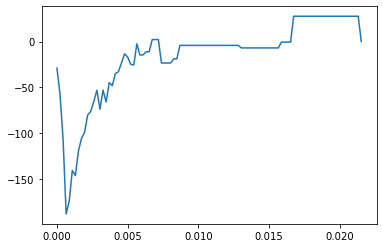

In [1302]:
yc_predict = model.predict(Xc_valp)
min_amplitude = np.linspace(0,np.max(np.abs(yc_predict)),100)
acc = []
prof = []
for j in min_amplitude:
    good = 0
    bad = 0
    ig = 0
    ib = 0
    ii = 0
    for i in range(len(yc_val)):
        if list(yc_predict)[i]>j:
            ii += 1
            if (list(yc_val)[i]>0)==(list(yc_predict)[i]>0):
                ig += 1
                good += (0.0001/list(Xc_val_change['Price'])[i])*1000*np.abs(list(Xc_val_change['Change'])[i])*10000
            else:
                ib += 1
                bad += (0.0001/list(Xc_val_change['Price'])[i])*1000*np.abs(list(Xc_val_change['Change'])[i])*10000
    
    if (ig+ib)==0:
        acc.append(1)
        prof.append(0)
        continue
        
    #print('Good: ',np.round(good,3))
    #print('Bad: ',np.round(bad,3))
    profit = np.round(good-bad,3)
    print('Profit: ',profit)

    accuracy = ig/(ig+ib)
    acc.append(accuracy)
    prof.append(profit)
    print('Accuracy: ',np.round(accuracy,5))

    MSE_test = mean_squared_error(yc_val,yc_predict)
    #print('MSE: ',np.round(MSE_test,5))
    print(ii)
    print('\n')
    
plt.plot(min_amplitude,acc)

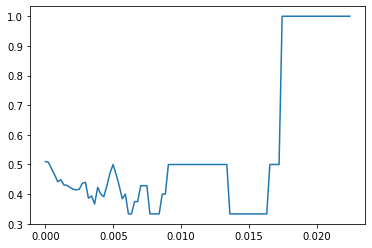

In [1304]:
plt.plot(min_amplitude,acc)

In [1316]:
yc_predict = model.predict(Xc_testp)
min_amplitude = np.linspace(0,np.max(np.abs(yc_predict)),100)

good = 0
bad = 0
ig = 0
ib = 0
ii = 0
for i in range(len(yc_test)):
    if list(yc_predict)[i]>0.005:
        ii += 1
        if (list(yc_test)[i]>0)==(list(yc_predict)[i]>0):
            ig += 1
            #good += np.abs(list(Xc_test_change['Change'])[i])
            good += (0.0001/list(Xc_test_change['Price'])[i])*1000*np.abs(list(Xc_test_change['Change'])[i])*10000
        else:
            ib += 1
            bad += (0.0001/list(Xc_test_change['Price'])[i])*1000*np.abs(list(Xc_test_change['Change'])[i])*10000
            #bad += np.abs(list(Xc_test_change['Change'])[i])

#print('Good: ',np.round(good,3))
#print('Bad: ',np.round(bad,3))
profit = np.round(good-bad,3)
print('Profit: ',profit)

accuracy = ig/(ig+ib)
print('Accuracy: ',np.round(accuracy,5))

MSE_test = mean_squared_error(yc_test,yc_predict)
#print('MSE: ',np.round(MSE_test,5))
print(ii)
print('\n')


Profit:  52.831
Accuracy:  0.53846
13




#### Trial 1

In [1066]:
model = GBR()

grid = dict()  # define the grid of values to search

grid['n_estimators'] = [10, 40, 80]
grid['learning_rate'] = [0.001, 0.01, 0.1, 1.0]
grid['subsample'] = [0.1, 0.5, 0.7, 1.0]
grid['max_depth'] = [3, 5, 7, 9]

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)


grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error',verbose=10)  # define the grid search procedure


grid_result = grid_search.fit(Xc_trainp, yc_train)  # execute the grid search


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # summarize the best score and configuration

means = grid_result.cv_results_['mean_test_score'] # summarize all scores that were evaluated
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 192 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1950s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0223s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   22.4s
[Parallel(n_jo

Best: -0.005494 using {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.1}
-0.005496 (0.000270) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.1}
-0.005496 (0.000270) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
-0.005496 (0.000270) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
-0.005496 (0.000269) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
-0.005495 (0.000269) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 40, 'subsample': 0.1}
-0.005496 (0.000269) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 40, 'subsample': 0.5}
-0.005496 (0.000269) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 40, 'subsample': 0.7}
-0.005497 (0.000268) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 40, 'subsample': 1.0}
-0.005496 (0.000270) with: {'learning_rate': 0.001, 

In [1317]:
model = GBR(learning_rate= 0.01, max_depth= 5, n_estimators= 10, subsample= 0.1,random_state=1)
model.fit(Xc_trainp, yc_train)
yc_predict = model.predict(Xc_trainp)
yc_predict_val = model.predict(Xc_valp)

In [1318]:
good = 0
bad = 0
ig = 0
ib = 0
for i in range(len(yc_train)):

    if np.sign(list(yc_train)[i])==np.sign(list(yc_predict)[i]):
        ig += 1
        good += np.abs(list(Xc_train_change['Change'])[i])
    else:
        ib += 1
        bad += np.abs(list(Xc_train_change['Change'])[i])

print('Profit: ',np.round(good-bad,3))

accuracy = ig/(ig+ib)
print('Accuracy: ',np.round(accuracy,5))

MAE_train = mean_absolute_error(yc_train,yc_predict)
MAE_val = mean_absolute_error(yc_val,yc_predict_val)
print('MAE: ',np.round(MAE_train,5))
print('MAE_val: ',np.round(MAE_val,5))

Profit:  0.641
Accuracy:  0.52556
MAE:  0.00548
MAE_val:  0.00561


In [1321]:
yc_predict = model.predict(Xc_testp)
min_amplitude = np.linspace(0,np.max(np.abs(yc_predict)),100)

good = 0
bad = 0
ig = 0
ib = 0
ii = 0
for i in range(len(yc_test)):
    if True:
        ii += 1
        if (list(yc_test)[i]>0)==(list(yc_predict)[i]>0):
            ig += 1
            #good += np.abs(list(Xc_test_change['Change'])[i])
            good += (0.0001/list(Xc_test_change['Price'])[i])*1000*np.abs(list(Xc_test_change['Change'])[i])*10000
        else:
            ib += 1
            bad += (0.0001/list(Xc_test_change['Price'])[i])*1000*np.abs(list(Xc_test_change['Change'])[i])*10000
            #bad += np.abs(list(Xc_test_change['Change'])[i])

#print('Good: ',np.round(good,3))
#print('Bad: ',np.round(bad,3))
profit = np.round(good-bad,3)
print('Profit: ',profit)

accuracy = ig/(ig+ib)
print('Accuracy: ',np.round(accuracy,5))

MSE_test = mean_squared_error(yc_test,yc_predict)
#print('MSE: ',np.round(MSE_test,5))
print(ii)
print('\n')
kappa = cohen_kappa_score(yc_test>0,yc_predict>0)

print('Kappa: ',np.round(kappa,4))

Profit:  -75.612
Accuracy:  0.49255
940


Kappa:  -0.0196


Profit:  -342.254
Accuracy:  0.4918
1098


Profit:  -327.84
Accuracy:  0.49173
1088


Profit:  -345.503
Accuracy:  0.49065
1070


Profit:  -411.583
Accuracy:  0.48808
1049


Profit:  -401.576
Accuracy:  0.48876
1023


Profit:  -398.98
Accuracy:  0.48998
998


Profit:  -430.322
Accuracy:  0.48828
981


Profit:  -461.462
Accuracy:  0.48319
952


Profit:  -421.403
Accuracy:  0.48397
936


Profit:  -347.927
Accuracy:  0.48639
882


Profit:  -312.143
Accuracy:  0.48944
852


Profit:  -356.665
Accuracy:  0.48154
677


Profit:  -352.64
Accuracy:  0.48228
649


Profit:  -374.071
Accuracy:  0.47434
565


Profit:  -279.548
Accuracy:  0.47809
502


Profit:  -244.101
Accuracy:  0.47236
398


Profit:  -253.348
Accuracy:  0.45399
326


Profit:  -252.938
Accuracy:  0.44251
287


Profit:  -172.166
Accuracy:  0.45291
223


Profit:  -129.468
Accuracy:  0.45349
172


Profit:  -94.39
Accuracy:  0.47771
157


Profit:  -108.17
Accuracy:  0.47297
148


Profit:  -109.43
Accuracy:  0.45669
127


Profit:  -126.

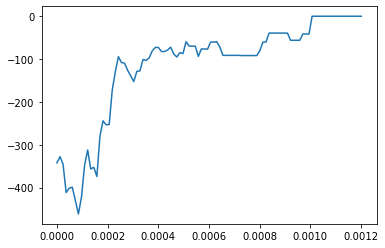

In [1322]:
yc_predict = model.predict(Xc_valp)
min_amplitude = np.linspace(0,np.max(np.abs(yc_predict)),100)
acc = []
prof = []
for j in min_amplitude:
    good = 0
    bad = 0
    ig = 0
    ib = 0
    ii = 0
    for i in range(len(yc_val)):
        if list(yc_predict)[i]>j:
            ii += 1
            if (list(yc_val)[i]>0)==(list(yc_predict)[i]>0):
                ig += 1
                good += (0.0001/list(Xc_val_change['Price'])[i])*1000*np.abs(list(Xc_val_change['Change'])[i])*10000
            else:
                ib += 1
                bad += (0.0001/list(Xc_val_change['Price'])[i])*1000*np.abs(list(Xc_val_change['Change'])[i])*10000
    
    if (ig+ib)<=1:
        acc.append(1)
        prof.append(0)
        continue
        
    #print('Good: ',np.round(good,3))
    #print('Bad: ',np.round(bad,3))
    profit = np.round(good-bad,3)
    print('Profit: ',profit)

    accuracy = ig/(ig+ib)
    acc.append(accuracy)
    prof.append(profit)
    print('Accuracy: ',np.round(accuracy,5))

    MSE_test = mean_squared_error(yc_val,yc_predict)
    #print('MSE: ',np.round(MSE_test,5))
    print(ii)
    print('\n')
    
plt.plot(min_amplitude,prof)

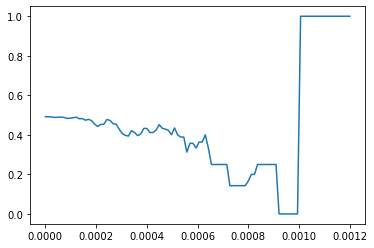

In [1323]:
plt.plot(min_amplitude,acc)

In [1324]:
yc_predict = model.predict(Xc_testp)
min_amplitude = np.linspace(0,np.max(np.abs(yc_predict)),100)

good = 0
bad = 0
ig = 0
ib = 0
for i in range(len(yc_test)):
    if (list(yc_test)[i]>0)==(list(yc_predict)[i]>0):
        ig += 1
        #good += np.abs(list(Xc_test_change['Change'])[i])
        good += (0.0001/list(Xc_test_change['Price'])[i])*1000*np.abs(list(Xc_test_change['Change'])[i])*10000
    else:
        ib += 1
        bad += (0.0001/list(Xc_test_change['Price'])[i])*1000*np.abs(list(Xc_test_change['Change'])[i])*10000
        #bad += np.abs(list(Xc_test_change['Change'])[i])

print('Good: ',np.round(good,3))
print('Bad: ',np.round(bad,3))
profit = np.round(good-bad,3)
print('Profit: ',profit)

accuracy = ig/(ig+ib)
print('Accuracy: ',np.round(accuracy,5))

MAE_test = mean_absolute_error(yc_test,yc_predict)
print('MAE: ',np.round(MAE_test,5))

Good:  1956.729
Bad:  2032.341
Profit:  -75.612
Accuracy:  0.49255
MAE:  0.00529
